In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [1]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-vyz8x2nv
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-vyz8x2nv
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0d2ab99cccbbc682722e708515fe9c4cfc50185a
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4716 sha256=407db4e0ff0c2d72ebb137d2cef87ddafeea94f69e5278857fc89277ffdbdccf
  Stored in directory: /tmp/pip-ephem-wheel-cache-33mdi4vh/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built NVCCPlugin


In [2]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


In [17]:
%%cu
#include <cuda.h>
#include <cuda_runtime.h>
#include <device_launch_parameters.h>
#include <stdio.h>
#include <time.h>
#include <sys/time.h>



// Define constants used in the program
#define N 30000 // Number of nodes in the graph
#define BQ_CAPACITY 2048 // Capacity of block queue in block queuing kernel
#define BLOCK_SIZE 512 // Number of threads per block
#define GRAPH_SIZE 30000 // Size of the graph (number of nodes)

// Define the global queuing kernel
__global__ void gpu_global_queuing_kernel(int *nodePtrs, int *nodeNeighbors, int *nodeVisited, int *currLevelNodes, int *nextLevelNodes, const unsigned int numCurrLevelNodes, int *numNextLevelNodes) {
    // Calculate the global index of the current thread
    int idx = threadIdx.x + blockIdx.x * blockDim.x;

    // Check if the index is within the range of current level nodes
    if (idx < numCurrLevelNodes) {
        // Get the node at the current level
        int node = currLevelNodes[idx];
        // Loop over the neighbors of the node
        for(int nbrIdx = nodePtrs[node]; nbrIdx < nodePtrs[node + 1]; nbrIdx++) {
            // Get the neighbor
            int neighbor = nodeNeighbors[nbrIdx];
            // If the neighbor has not been visited yet
            if (!nodeVisited[neighbor]) {
                // Mark the neighbor as visited
                nodeVisited[neighbor] = 1;
                // Add the neighbor to the next level nodes
                int pos = atomicAdd(numNextLevelNodes, 1);
                nextLevelNodes[pos] = neighbor;
            }
        }
    }
}

// Define the block queuing kernel
__global__ void gpu_block_queuing_kernel(int *nodePtrs, int *nodeNeighbors, int *nodeVisited, int *currLevelNodes, int *nextLevelNodes, const unsigned int numCurrLevelNodes, int *numNextLevelNodes) {
    // Declare shared memory block queue and its size
    __shared__ int blockQueue[BQ_CAPACITY];
    __shared__ int blockQueueSize;

    // Initialize the block queue size to 0
    if (threadIdx.x == 0) {
        blockQueueSize = 0;
    }
    // Synchronize all threads in the block
    __syncthreads();

    // Calculate the global index of the current thread
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    // Check if the index is within the range of current level nodes
    if (idx < numCurrLevelNodes) {
        // Get the node at the current level
        int node = currLevelNodes[idx];
        // Loop over the neighbors of the node
        for(int nbrIdx = nodePtrs[node]; nbrIdx < nodePtrs[node + 1]; nbrIdx++) {
            // Get the neighbor
            int neighbor = nodeNeighbors[nbrIdx];
            // If the neighbor has not been visited yet
            if (!nodeVisited[neighbor]) {
                // Mark the neighbor as visited
                nodeVisited[neighbor] = 1;
                // Add the neighbor to the block queue
                int pos = atomicAdd(&blockQueueSize, 1);
                // If the block queue is not full
                if (pos < BQ_CAPACITY) {
                    blockQueue[pos] = neighbor;
                } else {
                    // If the block queue is full, add the neighbor to the next level nodes
                    pos = atomicAdd(numNextLevelNodes, 1);
                    nextLevelNodes[pos] = neighbor;
                }
            }
        }
    }
    // Synchronize all threads in the block
    __syncthreads();

    // If the thread is the first thread in the block
    if (threadIdx.x == 0) {
        // Add the block queue to the next level nodes
        int globalPos = atomicAdd(numNextLevelNodes, blockQueueSize);
        for (int i = 0; i < blockQueueSize; i++) {
            nextLevelNodes[globalPos + i] = blockQueue[i];
        }
    }
}

// Define the global queuing function
void gpu_global_queuing(int *nodePtrs, int *nodeNeighbors, int *nodeVisited, int *currLevelNodes, int *nextLevelNodes, unsigned int numCurrLevelNodes, int *numNextLevelNodes) {
    const unsigned int numBlocks = 45; // Number of blocks to launch
    // Launch the global queuing kernel
    gpu_global_queuing_kernel<<<numBlocks, BLOCK_SIZE>>>(nodePtrs, nodeNeighbors, nodeVisited, currLevelNodes, nextLevelNodes, numCurrLevelNodes, numNextLevelNodes);
}

// Define the block queuing function
void gpu_block_queuing(int *nodePtrs, int *nodeNeighbors, int *nodeVisited, int *currLevelNodes, int *nextLevelNodes, unsigned int numCurrLevelNodes, int *numNextLevelNodes) {
    const unsigned int numBlocks = 45; // Number of blocks to launch
    // Launch the block queuing kernel
    gpu_block_queuing_kernel<<<numBlocks, BLOCK_SIZE>>>(nodePtrs, nodeNeighbors, nodeVisited, currLevelNodes, nextLevelNodes, numCurrLevelNodes, numNextLevelNodes);
}

// Define the BFS kernel
__global__ void BFS(int *d_graph, int *d_visited, int *d_over) {
    // Calculate the global index of the current thread
    int id = threadIdx.x + blockIdx.x * blockDim.x;
    // Check if the index is within the range of nodes and the node has been visited
    if (id < N && d_visited[id]) {
        // Mark the node as processed
        d_visited[id] = 2;
        // Loop over the neighbors of the node
        for (int i = 0; i < N; i++) {
            // If there is an edge between the node and its neighbor and the neighbor has not been visited
            if (d_graph[id * N + i] == 1 && d_visited[i] == 0) {
                // Mark the neighbor as discovered
                d_visited[i] = 1;
                // Set the flag to 1 to continue BFS
                *d_over = 1;
            }
        }
    }
}

// Define the BFS function
void GraphBFS(int *graph, int *visited, int start) {
    // Mark the start node as visited
    visited[start] = 1;

    // Declare device pointers
    int *d_graph, *d_visited, *d_over;

    // Calculate the size of the graph in bytes
    int size = N * N * sizeof(int);

    // Initialize the flag to 1
    int over = 1;

    // Allocate device memory
    cudaMalloc((void **)&d_graph, size);
    cudaMalloc((void **)&d_visited, N * sizeof(int));
    cudaMalloc((void **)&d_over, sizeof(int));

    // Copy data to device memory
    cudaMemcpy(d_graph, graph, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_visited, visited, N * sizeof(int), cudaMemcpyHostToDevice);

    // Calculate the dimensions of the grid and blocks
    dim3 gridDim((N + BLOCK_SIZE - 1) / BLOCK_SIZE);
    dim3 blockDim(BLOCK_SIZE);

    // Run BFS until there are no more nodes to visit
    while (over) {
        // Reset the flag
        over = 0;
        // Copy the flag to device memory
        cudaMemcpy(d_over, &over, sizeof(int), cudaMemcpyHostToDevice);
        // Launch the BFS kernel
        BFS<<<gridDim, blockDim>>>(d_graph, d_visited, d_over);
        // Wait for all threads to finish
        cudaDeviceSynchronize();
        // Copy the flag from device to host memory
        cudaMemcpy(&over, d_over, sizeof(int), cudaMemcpyDeviceToHost);
    }

    // Copy the result from device to host memory
    cudaMemcpy(visited, d_visited, N * sizeof(int), cudaMemcpyDeviceToHost);

    // Free device memory
    cudaFree(d_graph);
    cudaFree(d_visited);
    cudaFree(d_over);
}

// Define the sequential BFS function
void sequentialBFS(int *graph, int *visited, int start) {
    // Declare a queue for BFS
    int *queue = (int *)malloc(N * sizeof(int));
    int front = 0;
    int back = 0;

    // Mark the start node as discovered and enqueue it
    visited[start] = 1;
    queue[back++] = start;

    while (front < back) {
        // Dequeue a node from the queue
        int node = queue[front++];
        // Mark the node as processed
        visited[node] = 2;
        // Loop over the neighbors of the node
        for (int i = 0; i < N; i++) {
            // If there is an edge between the node and its neighbor and the neighbor has not been visited
            if (graph[node * N + i] == 1 && visited[i] == 0) {
                // Mark the neighbor as discovered and enqueue it
                visited[i] = 1;
                queue[back++] = i;
            }
        }
    }

    // Free the queue
    free(queue);
}


// Define the main function
int main() {
    // Seed the random number generator
    srand(time(NULL));

    // Allocate memory for the graph and visited array
    int *graph = (int *)malloc(GRAPH_SIZE * GRAPH_SIZE * sizeof(int));
    int *visited = (int *)calloc(GRAPH_SIZE, sizeof(int));
    double probability = 0.0001;

    // Generate a random adjacency matrix
    for (int i = 0; i < GRAPH_SIZE; i++) {
        for (int j = 0; j < GRAPH_SIZE; j++) {
            // Assign 1 to the cell with a probability of 0.probability, otherwise assign 0
            graph[i * GRAPH_SIZE + j] = (rand() < RAND_MAX * probability) ? 1 : 0;
        }
    }

    // Create copies of the graph and visited array
    int *graphCopy = (int *)malloc(GRAPH_SIZE * GRAPH_SIZE * sizeof(int));
    int *visitedCopy = (int *)calloc(GRAPH_SIZE, sizeof(int));
    memcpy(graphCopy, graph, GRAPH_SIZE * GRAPH_SIZE * sizeof(int));
    memcpy(visitedCopy, visited, GRAPH_SIZE * sizeof(int));

    // Measure the time taken by the CUDA BFS function
    struct timeval start, end;
    gettimeofday(&start, NULL);
    GraphBFS(graph, visited, 0);
    gettimeofday(&end, NULL);
    double elapsedCUDA = (end.tv_sec - start.tv_sec) + ((end.tv_usec - start.tv_usec)/1000000.0);
    printf("Time elapsed by CUDA BFS: %.6f seconds\n", elapsedCUDA);

    // Measure the time taken by the sequential BFS function
    gettimeofday(&start, NULL);
    sequentialBFS(graphCopy, visitedCopy, 0);
    gettimeofday(&end, NULL);
    double elapsedSequential = (end.tv_sec - start.tv_sec) + ((end.tv_usec - start.tv_usec)/1000000.0);
    printf("Time elapsed by sequential BFS: %.6f seconds\n", elapsedSequential);

    // Compute and print the ratio of times
    double ratio = (elapsedCUDA != 0) ? (elapsedSequential / elapsedCUDA) : 0;
    printf("Ratio of sequential BFS to CUDA BFS: %.6f\n", ratio);

    // Free host memory
    free(graph);
    free(visited);
    free(graphCopy);
    free(visitedCopy);

    return 0;
}

Time elapsed by CUDA BFS: 0.244828 seconds
Time elapsed by sequential BFS: 3.418057 seconds
Ratio of sequential BFS to CUDA BFS: 13.961054



In [23]:
%%cu
#include <cuda.h>
#include <cuda_runtime.h>
#include <device_launch_parameters.h>
#include <stdio.h>
#include <time.h>
#include <sys/time.h>



// Define constants used in the program
#define N 35000 // Number of nodes in the graph
#define BQ_CAPACITY 2048 // Capacity of block queue in block queuing kernel
#define BLOCK_SIZE 512 // Number of threads per block
#define GRAPH_SIZE 35000 // Size of the graph (number of nodes)

// Define the global queuing kernel
__global__ void gpu_global_queuing_kernel(int *nodePtrs, int *nodeNeighbors, int *nodeVisited, int *currLevelNodes, int *nextLevelNodes, const unsigned int numCurrLevelNodes, int *numNextLevelNodes) {
    // Calculate the global index of the current thread
    int idx = threadIdx.x + blockIdx.x * blockDim.x;

    // Check if the index is within the range of current level nodes
    if (idx < numCurrLevelNodes) {
        // Get the node at the current level
        int node = currLevelNodes[idx];
        // Loop over the neighbors of the node
        for(int nbrIdx = nodePtrs[node]; nbrIdx < nodePtrs[node + 1]; nbrIdx++) {
            // Get the neighbor
            int neighbor = nodeNeighbors[nbrIdx];
            // If the neighbor has not been visited yet
            if (!nodeVisited[neighbor]) {
                // Mark the neighbor as visited
                nodeVisited[neighbor] = 1;
                // Add the neighbor to the next level nodes
                int pos = atomicAdd(numNextLevelNodes, 1);
                nextLevelNodes[pos] = neighbor;
            }
        }
    }
}

// Define the block queuing kernel
__global__ void gpu_block_queuing_kernel(int *nodePtrs, int *nodeNeighbors, int *nodeVisited, int *currLevelNodes, int *nextLevelNodes, const unsigned int numCurrLevelNodes, int *numNextLevelNodes) {
    // Declare shared memory block queue and its size
    __shared__ int blockQueue[BQ_CAPACITY];
    __shared__ int blockQueueSize;

    // Initialize the block queue size to 0
    if (threadIdx.x == 0) {
        blockQueueSize = 0;
    }
    // Synchronize all threads in the block
    __syncthreads();

    // Calculate the global index of the current thread
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    // Check if the index is within the range of current level nodes
    if (idx < numCurrLevelNodes) {
        // Get the node at the current level
        int node = currLevelNodes[idx];
        // Loop over the neighbors of the node
        for(int nbrIdx = nodePtrs[node]; nbrIdx < nodePtrs[node + 1]; nbrIdx++) {
            // Get the neighbor
            int neighbor = nodeNeighbors[nbrIdx];
            // If the neighbor has not been visited yet
            if (!nodeVisited[neighbor]) {
                // Mark the neighbor as visited
                nodeVisited[neighbor] = 1;
                // Add the neighbor to the block queue
                int pos = atomicAdd(&blockQueueSize, 1);
                // If the block queue is not full
                if (pos < BQ_CAPACITY) {
                    blockQueue[pos] = neighbor;
                } else {
                    // If the block queue is full, add the neighbor to the next level nodes
                    pos = atomicAdd(numNextLevelNodes, 1);
                    nextLevelNodes[pos] = neighbor;
                }
            }
        }
    }
    // Synchronize all threads in the block
    __syncthreads();

    // If the thread is the first thread in the block
    if (threadIdx.x == 0) {
        // Add the block queue to the next level nodes
        int globalPos = atomicAdd(numNextLevelNodes, blockQueueSize);
        for (int i = 0; i < blockQueueSize; i++) {
            nextLevelNodes[globalPos + i] = blockQueue[i];
        }
    }
}

// Define the global queuing function
void gpu_global_queuing(int *nodePtrs, int *nodeNeighbors, int *nodeVisited, int *currLevelNodes, int *nextLevelNodes, unsigned int numCurrLevelNodes, int *numNextLevelNodes) {
    const unsigned int numBlocks = 45; // Number of blocks to launch
    // Launch the global queuing kernel
    gpu_global_queuing_kernel<<<numBlocks, BLOCK_SIZE>>>(nodePtrs, nodeNeighbors, nodeVisited, currLevelNodes, nextLevelNodes, numCurrLevelNodes, numNextLevelNodes);
}

// Define the block queuing function
void gpu_block_queuing(int *nodePtrs, int *nodeNeighbors, int *nodeVisited, int *currLevelNodes, int *nextLevelNodes, unsigned int numCurrLevelNodes, int *numNextLevelNodes) {
    const unsigned int numBlocks = 45; // Number of blocks to launch
    // Launch the block queuing kernel
    gpu_block_queuing_kernel<<<numBlocks, BLOCK_SIZE>>>(nodePtrs, nodeNeighbors, nodeVisited, currLevelNodes, nextLevelNodes, numCurrLevelNodes, numNextLevelNodes);
}

// Define the BFS kernel
__global__ void BFS(int *d_graph, int *d_visited, int *d_over) {
    // Calculate the global index of the current thread
    int id = threadIdx.x + blockIdx.x * blockDim.x;
    // Check if the index is within the range of nodes and the node has been visited
    if (id < N && d_visited[id]) {
        // Mark the node as processed
        d_visited[id] = 2;
        // Loop over the neighbors of the node
        for (int i = 0; i < N; i++) {
            // If there is an edge between the node and its neighbor and the neighbor has not been visited
            if (d_graph[id * N + i] == 1 && d_visited[i] == 0) {
                // Mark the neighbor as discovered
                d_visited[i] = 1;
                // Set the flag to 1 to continue BFS
                *d_over = 1;
            }
        }
    }
}

// Define the BFS function
void GraphBFS(int *graph, int *visited, int start) {
    // Mark the start node as visited
    visited[start] = 1;

    // Declare device pointers
    int *d_graph, *d_visited, *d_over;

    // Calculate the size of the graph in bytes
    int size = N * N * sizeof(int);

    // Initialize the flag to 1
    int over = 1;

    // Allocate device memory
    cudaMalloc((void **)&d_graph, size);
    cudaMalloc((void **)&d_visited, N * sizeof(int));
    cudaMalloc((void **)&d_over, sizeof(int));

    // Copy data to device memory
    cudaMemcpy(d_graph, graph, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_visited, visited, N * sizeof(int), cudaMemcpyHostToDevice);

    // Calculate the dimensions of the grid and blocks
    dim3 gridDim((N + BLOCK_SIZE - 1) / BLOCK_SIZE);
    dim3 blockDim(BLOCK_SIZE);

    // Run BFS until there are no more nodes to visit
    while (over) {
        // Reset the flag
        over = 0;
        // Copy the flag to device memory
        cudaMemcpy(d_over, &over, sizeof(int), cudaMemcpyHostToDevice);
        // Launch the BFS kernel
        BFS<<<gridDim, blockDim>>>(d_graph, d_visited, d_over);
        // Wait for all threads to finish
        cudaDeviceSynchronize();
        // Copy the flag from device to host memory
        cudaMemcpy(&over, d_over, sizeof(int), cudaMemcpyDeviceToHost);
    }

    // Copy the result from device to host memory
    cudaMemcpy(visited, d_visited, N * sizeof(int), cudaMemcpyDeviceToHost);

    // Free device memory
    cudaFree(d_graph);
    cudaFree(d_visited);
    cudaFree(d_over);
}

// Define the sequential BFS function
void sequentialBFS(int *graph, int *visited, int start) {
    // Declare a queue for BFS
    int *queue = (int *)malloc(N * sizeof(int));
    int front = 0;
    int back = 0;

    // Mark the start node as discovered and enqueue it
    visited[start] = 1;
    queue[back++] = start;

    while (front < back) {
        // Dequeue a node from the queue
        int node = queue[front++];
        // Mark the node as processed
        visited[node] = 2;
        // Loop over the neighbors of the node
        for (int i = 0; i < N; i++) {
            // If there is an edge between the node and its neighbor and the neighbor has not been visited
            if (graph[node * N + i] == 1 && visited[i] == 0) {
                // Mark the neighbor as discovered and enqueue it
                visited[i] = 1;
                queue[back++] = i;
            }
        }
    }

    // Free the queue
    free(queue);
}


// Define the main function
int main() {
    // Seed the random number generator
    srand(time(NULL));

    // Allocate memory for the graph and visited array
    int *graph = (int *)malloc(GRAPH_SIZE * GRAPH_SIZE * sizeof(int));
    int *visited = (int *)calloc(GRAPH_SIZE, sizeof(int));
    double probability = 0.0001;

    // Generate a random adjacency matrix
    for (int i = 0; i < GRAPH_SIZE; i++) {
        for (int j = 0; j < GRAPH_SIZE; j++) {
            // Assign 1 to the cell with a probability of 0.probability, otherwise assign 0
            graph[i * GRAPH_SIZE + j] = (rand() < RAND_MAX * probability) ? 1 : 0;
        }
    }

    // Create copies of the graph and visited array
    int *graphCopy = (int *)malloc(GRAPH_SIZE * GRAPH_SIZE * sizeof(int));
    int *visitedCopy = (int *)calloc(GRAPH_SIZE, sizeof(int));
    memcpy(graphCopy, graph, GRAPH_SIZE * GRAPH_SIZE * sizeof(int));
    memcpy(visitedCopy, visited, GRAPH_SIZE * sizeof(int));

    // Measure the time taken by the CUDA BFS function
    struct timeval start, end;
    gettimeofday(&start, NULL);
    GraphBFS(graph, visited, 0);
    gettimeofday(&end, NULL);
    double elapsedCUDA = (end.tv_sec - start.tv_sec) + ((end.tv_usec - start.tv_usec)/1000000.0);
    printf("GPU | Çalışma Süresi: %f saniye | Boyut: %d\n", elapsedCUDA, GRAPH_SIZE );

    FILE *file = fopen("bfs_results.log", "a");
    fprintf(file, "GPU | Çalışma Süresi: %f saniye | Boyutu: %d\n", elapsedCUDA, GRAPH_SIZE);

    fclose(file);


    // Measure the time taken by the sequential BFS function
    gettimeofday(&start, NULL);
    sequentialBFS(graphCopy, visitedCopy, 0);
    gettimeofday(&end, NULL);
    double elapsedSequential = (end.tv_sec - start.tv_sec) + ((end.tv_usec - start.tv_usec)/1000000.0);
    printf("CPU | Çalışma Süresi: %f saniye | Boyut: %d\n", elapsedSequential, GRAPH_SIZE );

    FILE *file2 = fopen("bfs_results.log", "a");
    fprintf(file2, "CPU | Çalışma Süresi: %f saniye | Boyut: %d\n", elapsedSequential, GRAPH_SIZE);

    fclose(file2);


    // Compute and print the ratio of times
    //double ratio = (elapsedCUDA != 0) ? (elapsedSequential / elapsedCUDA) : 0;
    //printf("Ratio of sequential BFS to CUDA BFS: %.6f\n", ratio);

    // Free host memory
    free(graph);
    free(visited);
    free(graphCopy);
    free(visitedCopy);

    return 0;
}

GPU | Çalışma Süresi: 0.583465 saniye | Boyut: 35000
CPU | Çalışma Süresi: 2.239941 saniye | Boyut: 35000



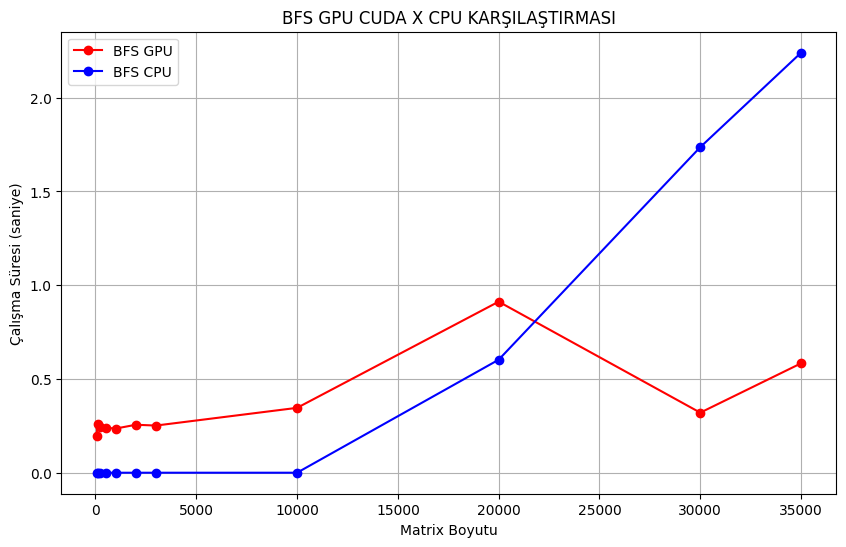

In [24]:
import matplotlib.pyplot as plt

gpu_times = []
cpu_times = []
sizes = []

with open('bfs_results.log', 'r') as file:
    for line in file:
        parts = line.split(' ')
        time = float(parts[4])
        size = int(parts[8])

        if 'GPU' in line:
            gpu_times.append(time)
        elif 'CPU' in line:
            cpu_times.append(time)

        sizes.append(size)

gpu_sizes = sizes[::2]
cpu_sizes = sizes[1::2]

plt.figure(figsize=(10, 6))

plt.plot(gpu_sizes, gpu_times, marker='o', label='BFS GPU', color='red')
plt.plot(cpu_sizes, cpu_times, marker='o', label='BFS CPU', color = 'blue')

plt.title('BFS GPU CUDA X CPU KARŞILAŞTIRMASI')
plt.xlabel('Matrix Boyutu')
plt.ylabel('Çalışma Süresi (saniye)')
plt.legend()
plt.grid(True)
plt.show()